In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle
import pygame

import sys, os
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd().split("PCNN")[0], "PCNN/src/"))
from game.constants import *
import core.build.pclib as pclib
import libs.pclib2 as pclib2
import utils
from game import envs as games
import game.objects as objects
import simulations as sim
import analysis.study_density as sd

logger = utils.setup_logger('An.DNS', level=3)


#import pcnn_core as pcr
from IPython.display import clear_output
from tqdm import tqdm
import time, json, os

%load_ext autoreload
%autoreload 2

logger()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


An.DNS | 2025-04-22 20:48:48 | 
An.DNS | 2025-04-22 20:48:48 | 


In [5]:
MPATH = "../media/plots"

In [6]:
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

#### settings

In [52]:
""" SETTINGS """


reward_settings = {
    "rw_fetching": "probabilistic",
    "rw_value": "discrete",
    "rw_position": np.array([0.5, 0.3]) * GAME_SCALE,
    "rw_radius": 0.08 * GAME_SCALE,
    "rw_sigma": 0.8,# * GAME_SCALE,
    "rw_bounds": np.array([0.23, 0.77,
                           0.23, 0.77]) * GAME_SCALE,
    "delay": 200,
    "silent_duration": 10_000,
    "fetching_duration": 10,
    "transparent": False,
    "beta": 40.,
    "alpha": 0.06,# * GAME_SCALE,
    "tau": 300,# * GAME_SCALE,
    "move_threshold": 4000,# * GAME_SCALE,
}

game_settings = {
    "plot_interval": 5,
    "rw_event": "move agent",
    "rendering": True,
    "agent_bounds": np.array([0.23, 0.77,
                              0.23, 0.77]) * GAME_SCALE,
    "max_duration": 25_000,
    "room_thickness": 30,
    "t_teleport": 1000,
    "limit_position_len": 1,
    "seed": None,
    "pause": -1,
    "verbose": True
}

global_parameters = {
    "local_scale": 0.02,
    # "local_scale_fine": 0.02,
    # "local_scale_coarse": 0.006,
    "N": 27**2,
    # "N": 42**2,
    # "Nc": 35**2,
    "use_sprites": False,
    "speed": 0.7,
    "min_weight_value": 0.5
}

parameters = {
        "gain": 25.0,
        "offset": 1.05,
        "threshold": 0.3,
        "rep_threshold": 0.9,
        "rec_threshold": 63,
        "tau_trace": 20,
        "remap_tag_frequency": 1,
        "min_rep_threshold": 0.95,

        "lr_da": 0.9,
        "lr_pred": 0.01,
        "threshold_da": 0.04,
        "tau_v_da": 3.0,

        "lr_bnd": 0.9,
        "threshold_bnd": 0.01,
        "tau_v_bnd": 3.0,

        "tau_ssry": 437.0,
        "threshold_ssry": 1.986,
        "threshold_circuit": 0.9,

        "rwd_weight": 0.7,
        "rwd_sigma": 80.,
        "col_weight": 0.,
        "col_sigma": 2.6,
        "rwd_field_mod": 1.0,
        "col_field_mod": 2.6,

        "action_delay": 120.0,
        "edge_route_interval": 10,
        "forced_duration": 19,
        "min_weight_value": 0.2
}



#### run

In [57]:

""" settings """
duration = 40_000
t_room_change = 25_000
reward_settings["silent_duration"] = 10_000

verbose_min = True
verbose = True
record_flag = False
pause = -1
t_teleport=game_settings["t_teleport"]
plot_interval=game_settings["plot_interval"]

In [ ]:

""" make model """

brain = pclib2.Brain(
            local_scale=global_parameters["local_scale"],
            N=global_parameters["N"],
            rec_threshold=parameters["rec_threshold"],
            speed=global_parameters["speed"],
            min_rep_threshold=parameters["min_rep_threshold"],
            gain=parameters["gain"],
            offset=parameters["offset"],
            threshold=parameters["threshold"],
            rep_threshold=parameters["rep_threshold"],
            tau_trace=parameters["tau_trace"],
            remap_tag_frequency=parameters["remap_tag_frequency"],
            lr_da=parameters["lr_da"],
            lr_pred=parameters["lr_pred"],
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            rwd_field_mod=parameters["rwd_field_mod"],
            col_field_mod=parameters["col_field_mod"],
            action_delay=parameters["action_delay"],
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            min_weight_value=parameters["min_weight_value"])

""" make game environment """

room = games.make_room(name="Square.v0",
                       thickness=game_settings["room_thickness"],
                       bounds=[0, 1, 0, 1])
room_2 = games.make_room(name="Square.b",
                       thickness=game_settings["room_thickness"],
                       bounds=[0, 1, 0, 1])
room_bounds = [room.bounds[0]+10, room.bounds[2]-10,
               room.bounds[1]+10, room.bounds[3]-10]

# ===| objects |===

possible_positions = room.get_room_positions()

agent_possible_positions = possible_positions.copy()
agent_position = room.sample_next_position()

rw_tau = reward_settings["tau"] if "tau" in reward_settings else 400
if "move_threlshold" in reward_settings:
    rw_move_threshold = reward_settings["move_threshold"]
else:
    rw_move_threshold = 2

reward_obj = objects.RewardObj(
            position=possible_positions[0],
            possible_positions=possible_positions,
            radius=reward_settings["rw_radius"],
            sigma=reward_settings["rw_sigma"],
            fetching=reward_settings["rw_fetching"],
            value=reward_settings["rw_value"],
            bounds=room_bounds,
            delay=reward_settings["delay"],
            silent_duration=reward_settings["silent_duration"],
            fetching_duration=reward_settings["fetching_duration"],
            use_sprites=global_parameters["use_sprites"],
            tau=rw_tau,
            move_threshold=rw_move_threshold,
            transparent=reward_settings["transparent"])

body = objects.AgentBody(
            position=agent_position,
            speed=global_parameters["speed"],
            possible_positions=agent_possible_positions,
            bounds=game_settings["agent_bounds"],
            use_sprites=global_parameters["use_sprites"],
            limit_position_len=game_settings["limit_position_len"],
            room=room,
            color=(10, 10, 10))

logger(reward_obj)


# --- env
env = games.Environment(room=room,
                        agent=body,
                        reward_obj=reward_obj,
                        duration=duration,
                        rw_event=game_settings["rw_event"],
                        verbose=False,
                        visualize=game_settings["rendering"])
logger(env)


""" run game """

logger("[@simulations.py]")

# ===| setup |===
clock = pygame.time.Clock()
last_position = np.zeros(2)

# [position, velocity, collision, reward, done, terminated]
observation = [[0., 0.], 0., 0., False, False]
prev_position = env.position
room_changed = False

record = {"activity": [],
          "trajectory": []}


# ===| main loop |===
for _ in tqdm(range(env.duration), desc="Game", leave=False,
              disable=not verbose_min):

    # Event handling
    if env.visualize:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    # -check: teleport
    if env.t % t_teleport == 0 and env.reward_obj.is_silent: # <=========================
        env._reset_agent_position(brain, True)

    # -check: change room
    if env.t > t_room_change and not room_changed:
        env.room = room_2
        body.room = room_2
        logger(f"Room change -> {env.room}")
        room_changed = True
        env.set_time_flag()

    # velocity
    v = [(env.position[0] - prev_position[0]),
         (-env.position[1] + prev_position[1])]

    # brain step
    try:
        velocity = brain(v,
                         observation[1],
                         observation[2],
                         env.reward_availability)
    except IndexError:
        logger.debug(f"IndexError: {len(observation)}")
        raise IndexError
    # velocity = np.around(velocity, 2)

    # store past position
    prev_position = env.position

    # env step
    observation = env(velocity=np.array([velocity[0], -velocity[1]]),
                      brain=brain)

    # -check: reset agent's brain
    if observation[3]:
        if verbose and verbose_min:
            logger.info(">> Game reset <<")
        break


    # -check: record
    if record_flag:
        record["activity"] += [brain.get_representation()]
        record["trajectory"] += [env.position]

    # -check: exit
    if observation[4]:
        if verbose and verbose_min:
            logger.debug(">> Game terminated <<")
        break

    # pause
    if pause > 0:
        pygame.time.wait(pause)

pygame.quit()

logger(f"rw_count={env.rw_count}")


An.DNS | 2025-04-22 21:07:10 | Reward(300.0, 300.0, probabilistic, dur=10
An.DNS | 2025-04-22 21:07:10 | Reward(300.0, 300.0, probabilistic, dur=10
An.DNS | 2025-04-22 21:07:10 | Environment(Room(Square.v0), duration=40000, verbose=False)
An.DNS | 2025-04-22 21:07:10 | Environment(Room(Square.v0), duration=40000, verbose=False)
An.DNS | 2025-04-22 21:07:10 | [@simulations.py]
An.DNS | 2025-04-22 21:07:10 | [@simulations.py]
Game:  42%|███████████████▍                     | 16705/40000 [00:29<01:06, 352.85it/s]

In [69]:
env.time_flag, len(env.trajectory_set)

(24, 42)

In [104]:
reward_obj.position

array([300., 300.])

In [55]:
pc = brain.get_space_centers()
bnd = brain.get_bnd_weights()

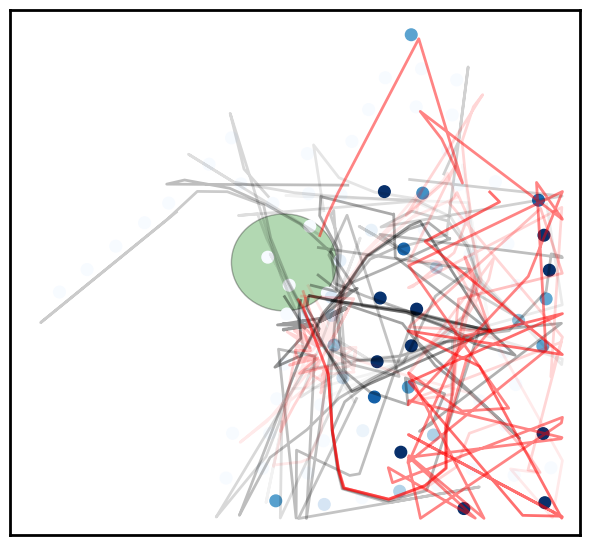

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Create axis with thicker borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Thicker border lines

circle = Circle(reward_obj.position, reward_obj.radius,
                edgecolor='black', facecolor='green', alpha=0.3)
ax.add_patch(circle)

#ax.scatter(*np.array(pc).T+np.array([300, 300]).reshape(-1, 1), alpha=0.9, edgecolor='black', facecolor='none')
ax.scatter(*np.array(pc).T+np.array([300, 300]).reshape(-1, 1), c=bnd, alpha=1., s=70, cmap="Blues", vmax=0.5)

for i, tr in enumerate(env.trajectory_set[1:env.time_flag]):
    _tr = np.array(tr).T
    _tr[1] = 600 - _tr[1]
    ax.plot(*_tr, 'k-', lw=2, alpha=(i+1)/(1+2*env.time_flag))

for i, tr in enumerate(env.trajectory_set[env.time_flag:]):
    _tr = np.array(tr).T
    _tr[1] = 600 - _tr[1]
    ax.plot(*_tr, 'r-', lw=2, alpha=(i+1)/(1+0.6*env.time_flag))

ax.set_xlim(50, 570)
ax.set_ylim(30, 550)
ax.set_xticks(())
ax.set_yticks(())
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()